In [1]:
using QuPhys # https://github.com/albertomercurio/QuPhys.jl version 0.4.0
using Arpack
using Optim # used to find the points where two eigenvalues cross
using PyPlot

geomspace(start, stop, n) = exp10.(range(log10(start), stop = log10(stop), length = n))

plt.rc("text", usetex = true)
plt.rc("text.latex", preamble = raw"\usepackage{amsmath} \usepackage{physics}")
plt.rc("axes", labelpad = 2)
plt.rc("legend", frameon = false)
plt.rc("font", size = 14)
plt.rc("axes", labelsize = 14)    # fontsize of the x and y labels
plt.rc("xtick", labelsize = 14)    # fontsize of the tick labels
plt.rc("ytick", labelsize = 14)    # fontsize of the tick labels
plt.rc("legend", fontsize = 13)

## Number of bare photons as a function of $\eta$

In [16]:
Nc = 50

a = kron(destroy(Nc), eye(2))

σx = kron(eye(Nc), sigmax())
σz = kron(eye(Nc), sigmaz())
σy = kron(eye(Nc), sigmay())

# quantum Rabi Hamiltonian in the dipole gauge
H_D(ωc, ωeg, η) = ωc * a'*a + ωeg/2 * σz - 1im * η * (a - a') * σx + η^2 * ωc

# quantum Rabi Hamiltonian in the Coulomb gauge
H_C(ωc, ωeg, η) = ωc * a'*a + ωeg/2 * ( σz * cosm(2*η*(a + a')) + σy * sinm(2*η*(a + a')) )

function ground_state_photons_D(η)
    H_op = H_D(ωc, ωeg, η)
    # E, U = eigen(H_op)
    E, U = eigs(H_op.data, nev=1, sigma=-2)
    ψGS = QuantumObject(U[:, 1], dims=H_op.dims)
    return expect(a'*a, ψGS)
end

function ground_state_photons_C(η)
    H_op = H_C(ωc, ωeg, η)
    H_op = (H_op + H_op')/2 # Due to numerical instabilities it is not always Harmitian
    # E, U = eigen(H_op)
    E, U = eigs(H_op.data, nev=1, sigma=-2)
    ψGS = QuantumObject(U[:, 1], dims=H_op.dims)
    return expect(a'*a, ψGS)
end

ground_state_photons_C (generic function with 1 method)

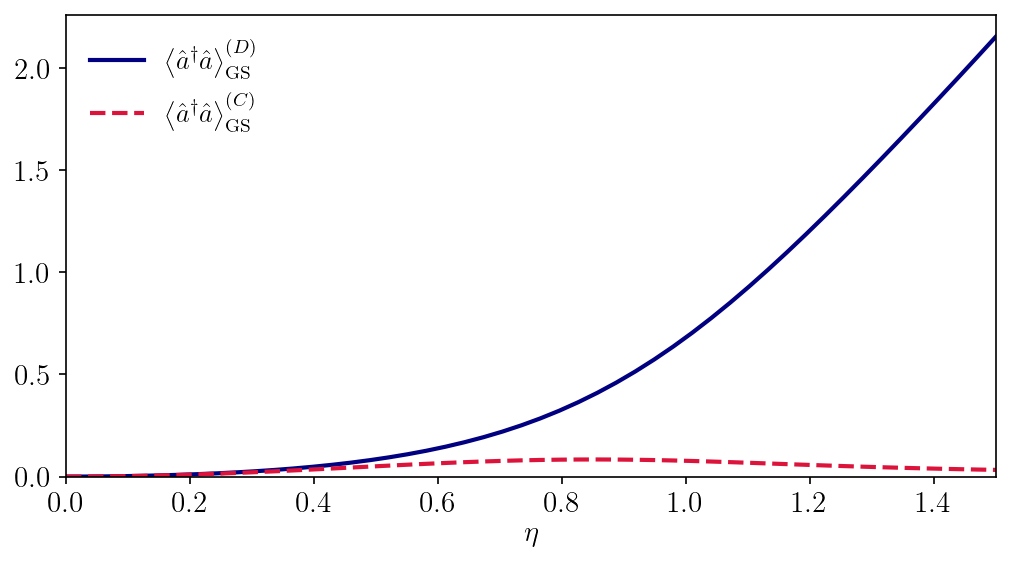

In [17]:
ωc = 1
ωeg = 1

η_list = range(0, 1.5, 50)
n_list_D = ground_state_photons_D.(η_list)
n_list_C = ground_state_photons_C.(η_list)

fig, ax = plt.subplots(dpi=150, figsize=(8, 4))

ax.plot(η_list, n_list_D, color="navy", lw=2, label=raw"$\expval{\hat{a}^\dagger \hat{a}}_{\textrm{GS}}^{(D)}$")
ax.plot(η_list, n_list_C, color="crimson", lw=2, ls="--", label=raw"$\expval{\hat{a}^\dagger \hat{a}}_{\textrm{GS}}^{(C)}$")
ax.set_xlabel(raw"$\eta$")
# ax.set_ylabel(raw"$\expval{\hat{a}^\dagger \hat{a}}_{\textrm{GS}}$")
ax.set_xlim(η_list[1], η_list[end])
ax.set_ylim(0, nothing)
ax.legend()

# root_dir = "/home/alberto/"
root_dir = "/mnt/c/Users/alber/"
plt.savefig(root_dir * "OneDrive/GitHub/Latex-Projects/phd-thesis/figures/photons_in_groundstate_vs_eta.pdf", dpi=300, bbox_inches="tight")

## Output photon rate and spectrum for an incoherently driven atom

In [19]:
Nc = 80

a = kron(destroy(Nc), eye(2))

σm = kron(eye(Nc), sigmam())
σx = kron(eye(Nc), sigmax())
σz = kron(eye(Nc), sigmaz())
σy = kron(eye(Nc), sigmay())

# Jaynes-Cummings Hamiltonian
H_JC(ωc, ωeg, η) = ωc * a'*a + ωeg/2 * σz + η * ωc * (a * σm' + a' * σm)

# quantum Rabi Hamiltonian in the dipole gauge
H_D(ωc, ωeg, η) = ωc * a'*a + ωeg/2 * σz - 1im * η * ωc * (a - a') * σx + η^2 * ωc

# quantum Rabi Hamiltonian in the Coulomb gauge
H_C(ωc, ωeg, η) = ωc * a'*a + ωeg/2 * ( σz * cosm(2*η*(a + a')) + σy * sinm(2*η*(a + a')) )

function emission_rate_correct(η, T)
    H_op = H_D(ωc, ωeg, η)
    fields = [sqrt(κc)*( 1im*(a-a') - 2*η*σx ), sqrt(κa)*σx]
    T_list = [0, T]

    E, U, L = liouvillian_generalized(H_op, fields, T_list, N_trunc=N_trunc, tol=tol, σ_filter=100*κc)
    ρss = steadystate(L)
    X_op = dense_to_sparse( (U' * ( 1im*(a-a') - 2*η*σx ) * U)[1:N_trunc,1:N_trunc], tol)
    X_op = QuantumObject(X_op)
    Xp = triu(X_op, 1)

    expect(Xp' * Xp, ρss)
end

function emission_rate_dressed(η, T)
    H_op = H_D(ωc, ωeg, η)
    fields = [sqrt(κc)*( 1im*(a-a') - 2*η*σx ), sqrt(κa)*σx]
    T_list = [0, T]

    E, U = eigen(H_op)
    E = real.(E[1:N_trunc])
    U = QuantumObject(U, dims=H_op.dims)

    H_d = QuantumObject(spdiagm(E))
    L = liouvillian(H_d)
    for ii in eachindex(fields)
        field_new = dense_to_sparse( (U' * fields[ii] * U)[1:N_trunc,1:N_trunc], tol)
        field_new = QuantumObject(field_new)
        for j in eachindex(E)
            for k in j+1:length(E)
                ωkj = E[k]-E[j]
                Γjk = ωkj * abs2(dot(U[:,j], fields[ii].data, U[:,k]))
                L += Γjk * n_th(ωkj, T_list[ii]) * lindblad_dissipator(projection(N_trunc, k-1, j-1))
                L += Γjk * (n_th(ωkj, T_list[ii])+1) * lindblad_dissipator(projection(N_trunc, j-1, k-1))
            end
        end
    end

    ρss = steadystate(L)
    X_op = dense_to_sparse( (U' * ( 1im*(a-a') - 2*η*σx ) * U)[1:N_trunc,1:N_trunc], tol)
    X_op = QuantumObject(X_op)
    Xp = triu(X_op, 1)

    expect(Xp' * Xp, ρss)
end

function emission_rate_wrong1(η, T)
    H_op = H_D(ωc, ωeg, η)
    fields = [sqrt(κc)*1im*(a-a'), sqrt(κa)*σx]
    T_list = [0, T]

    E, U, L = liouvillian_generalized(H_op, fields, T_list, N_trunc=N_trunc, tol=tol, σ_filter=100*κc)
    ρss = steadystate(L)
    X_op = dense_to_sparse( (U' * ( 1im*(a-a') ) * U)[1:N_trunc,1:N_trunc], tol)
    X_op = QuantumObject(X_op)
    Xp = triu(X_op, 1)

    expect(Xp' * Xp, ρss)
end

function emission_rate_wrong2(η, T)
    H_op = H_JC(ωc, ωeg, η)

    E, U = eigen(H_op)
    U = QuantumObject(U, dims=H_op.dims)
    E = real.(E)

    H_d = QuantumObject(spdiagm(E[1:N_trunc]))
    a′ = dense_to_sparse( (U' * a * U)[1:N_trunc,1:N_trunc], tol)
    a′ = QuantumObject(a′)
    σm′ = dense_to_sparse( (U' * σm * U)[1:N_trunc,1:N_trunc], tol)
    σm′ = QuantumObject(σm′)

    c_ops = [sqrt(κc) * a′, sqrt(κa*(n_th(ωeg, T)+1)) * σm′, sqrt(κa*n_th(ωeg, T)) * σm′']
    L = liouvillian(H_d, c_ops)
    ρss = steadystate(L)

    expect(a′' * a′, ρss)
end

function cavity_spectrum(ω_list, η, T)
    H_op = H_D(ωc, ωeg, η)

    fields = [sqrt(κc)*( 1im*(a-a') - 2*η*σx ), sqrt(κa)*σx]
    T_list = [0, T]

    E, U, L = liouvillian_generalized(H_op, fields, T_list, N_trunc=N_trunc, tol=tol, σ_filter=100*κc)
    # X_op = dense_to_sparse( (U' * ( a + a' ) * U)[1:N_trunc,1:N_trunc], tol)
    X_op = dense_to_sparse( (U' * ( 1im*(a-a') - 2*η*σx ) * U)[1:N_trunc,1:N_trunc], tol)
    X_op = QuantumObject(X_op)
    Xp = triu(X_op, 1)

    ω_list2, spec = spectrum(L, ω_list, Xp', Xp, solver=ExponentialSeries(tol=tol))
    spec
    # @. (ω_list / ωc)^2 * spec
end

function cavity_spectrum_dressed(ω_list, η, T)
    H_op = H_D(ωc, ωeg, η)

    fields = [sqrt(κc)*( 1im*(a-a') - 2*η*σx ), sqrt(κa)*σx]
    T_list = [0, T]

    E, U = eigen(H_op)
    E = real.(E[1:N_trunc])
    U = QuantumObject(U, dims=H_op.dims)

    H_d = QuantumObject(spdiagm(E))
    L = liouvillian(H_d)
    for ii in eachindex(fields)
        field_new = dense_to_sparse( (U' * fields[ii] * U)[1:N_trunc,1:N_trunc], tol)
        field_new = QuantumObject(field_new)
        for j in eachindex(E)
            for k in j+1:length(E)
                ωkj = E[k]-E[j]
                Γjk = ωkj * abs2(dot(U[:,j], fields[ii].data, U[:,k]))
                L += Γjk * n_th(ωkj, T_list[ii]) * lindblad_dissipator(projection(N_trunc, k-1, j-1))
                L += Γjk * (n_th(ωkj, T_list[ii])+1) * lindblad_dissipator(projection(N_trunc, j-1, k-1))
            end
        end
    end

    # X_op = dense_to_sparse( (U' * ( a + a' ) * U)[1:N_trunc,1:N_trunc], tol)
    X_op = dense_to_sparse( (U' * ( 1im*(a-a') - 2*η*σx ) * U)[1:N_trunc,1:N_trunc], tol)
    X_op = QuantumObject(X_op)
    Xp = triu(X_op, 1)

    ω_list2, spec = spectrum(L, ω_list, Xp', Xp, solver=ExponentialSeries(tol=tol))
    spec
    # @. (ω_list / ωc)^2 * spec
end

function cavity_spectrum_wrong2(ω_list, η, T)
    H_op = H_JC(ωc, ωeg, η)

    E, U = eigen(H_op)
    U = QuantumObject(U, dims=H_op.dims)
    E = real.(E)

    H_d = QuantumObject(spdiagm(E[1:N_trunc]))
    a′ = dense_to_sparse( (U' * a * U)[1:N_trunc,1:N_trunc], tol)
    a′ = QuantumObject(a′)
    σm′ = dense_to_sparse( (U' * σm * U)[1:N_trunc,1:N_trunc], tol)
    σm′ = QuantumObject(σm′)

    c_ops = [sqrt(κc) * a′, sqrt(κa*(n_th(ωeg, T)+1)) * σm′, sqrt(κa*n_th(ωeg, T)) * σm′']
    L = liouvillian(H_d, c_ops)

    ω_list2, spec = spectrum(L, ω_list, a′', a′, solver=ExponentialSeries(tol=tol))
    spec
    # @. (ω_list / ωc)^2 * spec
end

cavity_spectrum_wrong2 (generic function with 1 method)

### Zero detuning

In [68]:
ωc = 1
ωeg = 1
κc = 1e-3
κa = 1e-4
N_trunc = 20
tol = 1e-15

η_list = geomspace(1e-6, 3, 500)
T1 = 0.05
T2 = 0.5

res_correct_T1 = similar(η_list)
res_dressed_T1 = similar(η_list)
res_wrong1_T1 = similar(η_list)
res_wrong2_T1 = similar(η_list)
res_correct_T2 = similar(η_list)
res_dressed_T2 = similar(η_list)
res_wrong1_T2 = similar(η_list)
res_wrong2_T2 = similar(η_list)

pr = Progress(length(η_list), showspeed=true)
Threads.@threads for i in eachindex(η_list)
    res_correct_T1[i] = emission_rate_correct(η_list[i], T1)
    res_dressed_T1[i] = emission_rate_dressed(η_list[i], T1)
    res_wrong1_T1[i] = emission_rate_wrong1(η_list[i], T1)
    res_wrong2_T1[i] = emission_rate_wrong2(η_list[i], T1)
    res_correct_T2[i] = emission_rate_correct(η_list[i], T2)
    res_dressed_T2[i] = emission_rate_dressed(η_list[i], T2)
    res_wrong1_T2[i] = emission_rate_wrong1(η_list[i], T2)
    res_wrong2_T2[i] = emission_rate_wrong2(η_list[i], T2)
    next!(pr)
end

Progress: 100%|███████████████████████████| Time: 0:00:10 (21.88 ms/it)


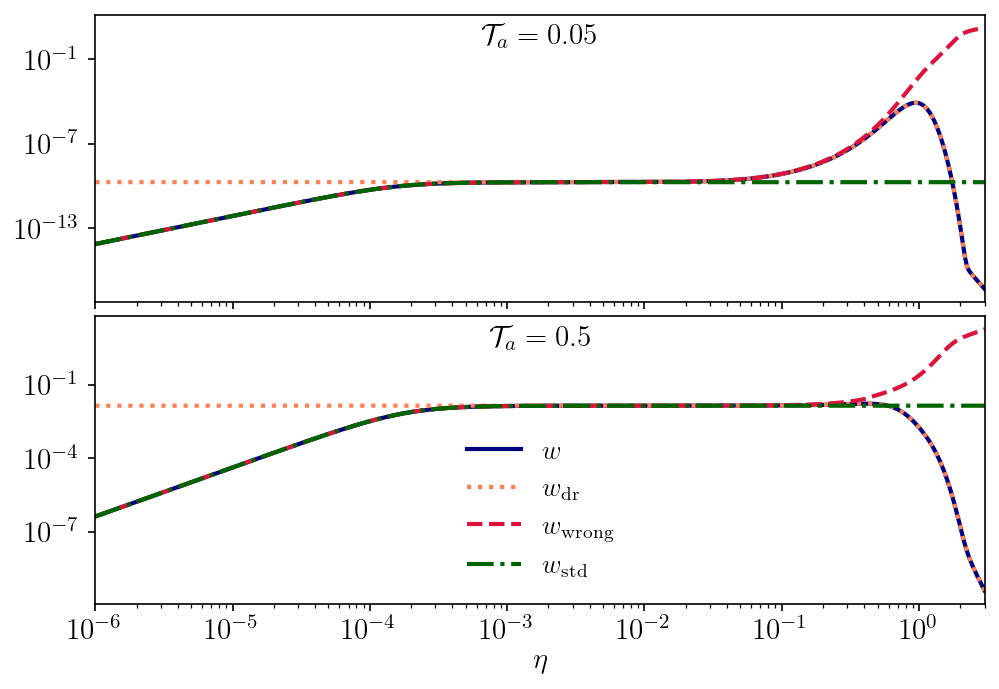

"/home/alberto/"

In [69]:
fig, axs = plt.subplots(2,1,sharex=true,dpi=150,figsize=(9*0.85,6*0.85), gridspec_kw=Dict("hspace"=>0.05, "wspace"=>0.05))

ax = axs[1]
ax.plot(η_list, res_correct_T1, color="navy", lw=2, label=raw"$w$")
ax.plot(η_list, res_dressed_T1, color="coral", lw=2, ls=":", label=raw"$w_{\textrm{dr}}$")
ax.plot(η_list, res_wrong1_T1, color="crimson", lw=2, ls="--", label=raw"$w_{\textrm{wrong}}$")
ax.plot(η_list, res_wrong2_T1, color="darkgreen", lw=2, ls="-.", label=raw"$w_{\textrm{std}}$")
ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_ylim(nothing, 1e4)
ax.text(0.5, 0.9, raw"$\mathcal{T}_a = 0.05$", transform=ax.transAxes, ha="center")
# ax.legend()

ax = axs[2]
ax.plot(η_list, res_correct_T2, color="navy", lw=2, label=raw"$w$")
ax.plot(η_list, res_dressed_T2, color="coral", lw=2, ls=":", label=raw"$w_{\textrm{dr}}$")
ax.plot(η_list, res_wrong1_T2, color="crimson", lw=2, ls="--", label=raw"$w_{\textrm{wrong}}$")
ax.plot(η_list, res_wrong2_T2, color="darkgreen", lw=2, ls="-.", label=raw"$w_{\textrm{std}}$")
ax.set_xlim(η_list[1], η_list[end])
ax.set_xlabel(raw"$\eta$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.text(0.5, 0.9, raw"$\mathcal{T}_a = 0.5$", transform=ax.transAxes, ha="center")
ax.legend()

root_dir = "/home/alberto/"
# root_dir = "/mnt/c/Users/alber/"
# plt.savefig(root_dir * "OneDrive/GitHub/Latex-Projects/phd-thesis/figures/emission_rate_vs_eta.pdf", dpi=300, bbox_inches="tight")

#### Possible transitions as a function of $\eta$

In [73]:
ωc = 1
ωeg = 1

function optim_objective(η, i, j)
    H_op = H_D(ωc, ωeg, η)

    E = eigs(H_op.data, nev=6, sigma=-2)[1]
    abs2(E[i] - E[j])
end

result = optimize(η -> optim_objective(η, 4, 3), 0.1, 0.7)
eta_inversion_2_3 = result.minimizer[1]
result = optimize(η -> optim_objective(η, 6, 5), 0.1, 0.7)
eta_inversion_4_5_1 = result.minimizer[1]
result = optimize(η -> optim_objective(η, 6, 5), 0.7, 1.3)
eta_inversion_4_5_2 = result.minimizer[1]

function freq_transitions(η)
    H_op = H_D(ωc, ωeg, η)

    E = eigs(H_op.data, nev=6, sigma=-2)[1]
    E = real.(E .- E[1])
    if η > eta_inversion_2_3
        E[3], E[4] = E[4], E[3]
    end
    if η > eta_inversion_4_5_1
        E[5], E[6] = E[6], E[5]
    end
    if η > eta_inversion_4_5_2
        E[5], E[6] = E[6], E[5]
    end

    return E
end

freq_transitions (generic function with 1 method)

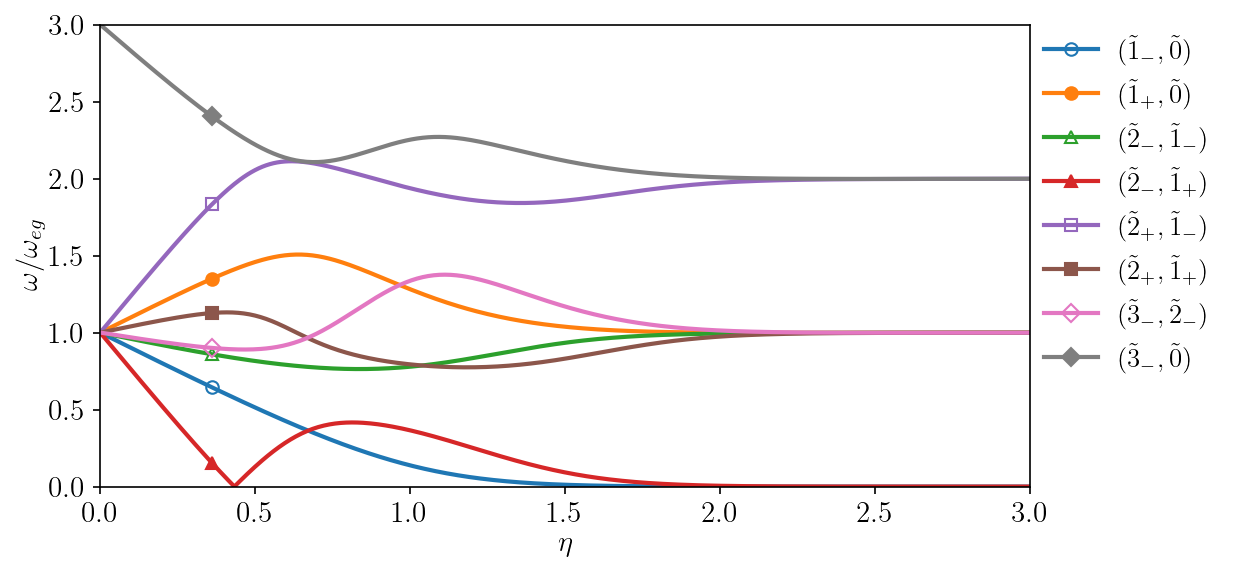

"/mnt/c/Users/alber/"

In [74]:
ωc = 1
ωeg = 1

η_list = range(0, 3, 500)
values = freq_transitions.(η_list)
values = hcat(values...)

fig, ax = plt.subplots(dpi = 150, figsize = (8, 4))

eigvect_notation = [raw"\tilde{0}", raw"\tilde{1}_{-}", raw"\tilde{1}_{+}", raw"\tilde{2}_{-}", raw"\tilde{2}_{+}", raw"\tilde{3}_{-}", raw"\tilde{3}_{+}"]

markers = ["o", "^", "s", "D", "X"]

j = 1
i = 0
ax.plot(η_list, abs.(values[j+1,:] - values[i+1,:]), label = raw"$(" * (eigvect_notation[j+1]) * raw", " * (eigvect_notation[i+1]) * raw")$", lw = 2, 
           marker = "o", markevery = [floor(Int, 0.12 * length(η_list))], markerfacecolor="none")
j = 2
i = 0
ax.plot(η_list, abs.(values[j+1,:] - values[i+1,:]), label = raw"$(" * (eigvect_notation[j+1]) * raw", " * (eigvect_notation[i+1]) * raw")$", lw = 2, 
           marker = "o", markevery = [floor(Int, 0.12 * length(η_list))])
j = 3
i = 1
ax.plot(η_list, abs.(values[j+1,:] - values[i+1,:]), label = raw"$(" * (eigvect_notation[j+1]) * raw", " * (eigvect_notation[i+1]) * raw")$", lw = 2, 
           marker = "^", markevery = [floor(Int, 0.12 * length(η_list))], markerfacecolor="none")
j = 3
i = 2
ax.plot(η_list, abs.(values[j+1,:] - values[i+1,:]), label = raw"$(" * (eigvect_notation[j+1]) * raw", " * (eigvect_notation[i+1]) * raw")$", lw = 2, 
           marker = "^", markevery = [floor(Int, 0.12 * length(η_list))])
j = 4
i = 1
ax.plot(η_list, abs.(values[j+1,:] - values[i+1,:]), label = raw"$(" * (eigvect_notation[j+1]) * raw", " * (eigvect_notation[i+1]) * raw")$", lw = 2, 
           marker = "s", markevery = [floor(Int, 0.12 * length(η_list))], markerfacecolor="none")
j = 4
i = 2
ax.plot(η_list, abs.(values[j+1,:] - values[i+1,:]), label = raw"$(" * (eigvect_notation[j+1]) * raw", " * (eigvect_notation[i+1]) * raw")$", lw = 2, 
           marker = "s", markevery = [floor(Int, 0.12 * length(η_list))])
j = 5
i = 3
ax.plot(η_list, abs.(values[j+1,:] - values[i+1,:]), label = raw"$(" * (eigvect_notation[j+1]) * raw", " * (eigvect_notation[i+1]) * raw")$", lw = 2, 
           marker = "D", markevery = [floor(Int, 0.12 * length(η_list))], markerfacecolor="none")
j = 5
i = 0
ax.plot(η_list, abs.(values[j+1,:] - values[i+1,:]), label = raw"$(" * (eigvect_notation[j+1]) * raw", " * (eigvect_notation[i+1]) * raw")$", lw = 2, 
           marker = "D", markevery = [floor(Int, 0.12 * length(η_list))])

ax.set_xlabel(raw"$\eta$")
ax.set_ylabel(raw"$\omega / \omega_{eg}$")
ax.set_xlim(η_list[1], η_list[end])
ax.set_ylim(0, 3)
ax.legend(bbox_to_anchor=(1.22, 1.03), loc="upper right")

# root_dir = "/home/alberto/"
root_dir = "/mnt/c/Users/alber/"
# plt.savefig(root_dir * "OneDrive/GitHub/Latex-Projects/phd-thesis/figures/freq_transitions_vs_eta.pdf", dpi=300, bbox_inches="tight")


#### Emission spectrum

Weak and strong coupling regimes

In [70]:
ωc = 1
ωeg = 1
κc = 1e-3
κa = 1e-4
N_trunc = 10
tol = 1e-15

η_list = geomspace(1e-6, 5e-2, 2000)
ω_list = range(0.96, 1.04, 2000)
T = 0.05

res_spectrum = similar(η_list, length(ω_list), length(η_list))
pr = Progress(length(η_list), showspeed=true)

Threads.@threads for i in eachindex(η_list)
    res_spectrum[:, i] = cavity_spectrum(ω_list, η_list[i], T)
    next!(pr)
end
res_spectrum ./= maximum(res_spectrum);

Progress: 100%|███████████████████████████| Time: 0:00:03 ( 1.82 ms/it)


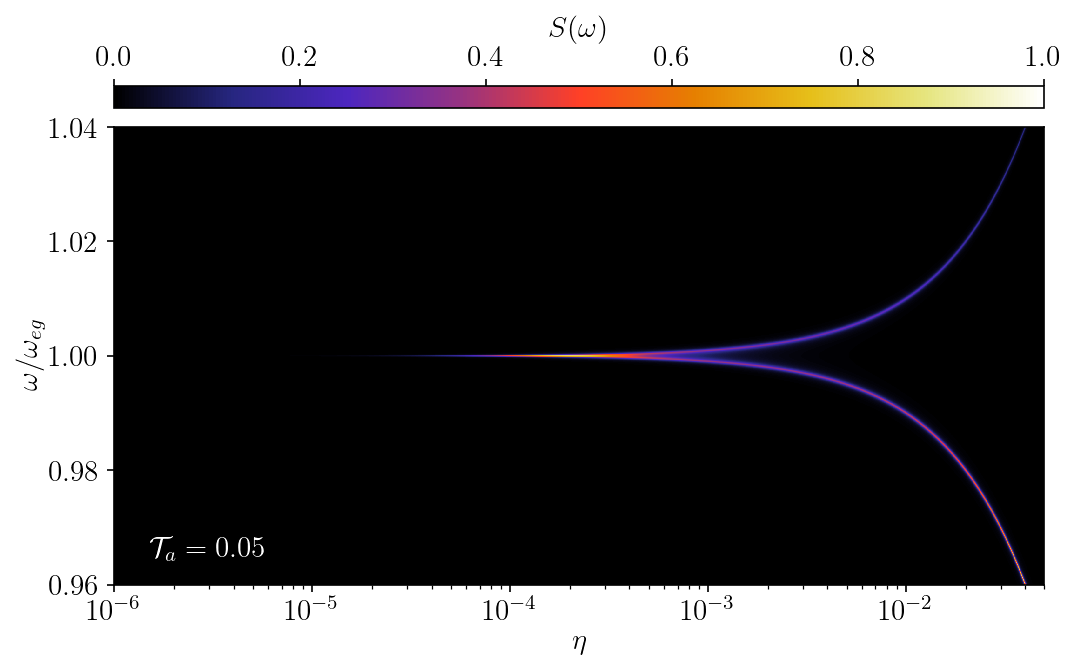

"/home/alberto/"

In [71]:
fig, ax = plt.subplots(dpi = 150, figsize = (8, 5))

img = ax.pcolormesh(η_list, ω_list, res_spectrum, shading="auto", cmap="CMRmap", rasterized=true)
ax.set_xlabel(raw"$\eta$")
ax.set_ylabel(raw"$\omega / \omega_{eg}$")
ax.set_xlim(η_list[1], η_list[end])
ax.set_ylim(ω_list[1], ω_list[end])
ax.set_xscale("log")
ax.text(0.0000015, 0.965, raw"$\mathcal{T}_a = " * string(0.05) * raw"$", color = "white")

fig.subplots_adjust(top = 0.72)
cbar_ax = fig.add_axes([0.125, 0.745, 0.775, 0.03])
colbar = fig.colorbar(img, cax=cbar_ax, orientation = "horizontal")
colbar.set_label(raw"$S(\omega)$", labelpad=-45)
cbar_ax.xaxis.set_ticks_position("top")

root_dir = "/home/alberto/"
# root_dir = "/mnt/c/Users/alber/"
# plt.savefig(root_dir * "OneDrive/GitHub/Latex-Projects/phd-thesis/figures/cavity_spectrum_vs_eta_weak_strong.pdf", dpi=300, bbox_inches="tight")

Ultrastrong and Deepstrong regimes

In [64]:
ωc = 1
ωeg = 1
κc = 1e-3
κa = 1e-4
N_trunc = 15
tol = 1e-15

η_list = range(1e-6, 2.5, 3000)
ω_list = range(1e-6, 2.5, 3000)
T1 = 0.05
T2 = 0.1
T3 = 0.2
T4 = 0.5

res_spectrum_T1 = similar(η_list, length(ω_list), length(η_list))
res_spectrum_T2 = similar(η_list, length(ω_list), length(η_list))
res_spectrum_T3 = similar(η_list, length(ω_list), length(η_list))
res_spectrum_T4 = similar(η_list, length(ω_list), length(η_list))

pr = Progress(length(η_list), showspeed=true)

Threads.@threads for i in eachindex(η_list)
    res_spectrum_T1[:, i] = cavity_spectrum(ω_list, η_list[i], T1)
    res_spectrum_T2[:, i] = cavity_spectrum(ω_list, η_list[i], T2)
    res_spectrum_T3[:, i] = cavity_spectrum(ω_list, η_list[i], T3)
    res_spectrum_T4[:, i] = cavity_spectrum(ω_list, η_list[i], T4)
    next!(pr)
end
res_spectrum_T1 ./= maximum(res_spectrum_T4)
res_spectrum_T2 ./= maximum(res_spectrum_T4)
res_spectrum_T3 ./= maximum(res_spectrum_T4)
res_spectrum_T4 ./= maximum(res_spectrum_T4);

Progress: 100%|███████████████████████████| Time: 0:00:54 (18.14 ms/it)


In [56]:
@. res_spectrum_T1 = abs(res_spectrum_T1)
@. res_spectrum_T2 = abs(res_spectrum_T2)
@. res_spectrum_T3 = abs(res_spectrum_T3)
@. res_spectrum_T4 = abs(res_spectrum_T4);

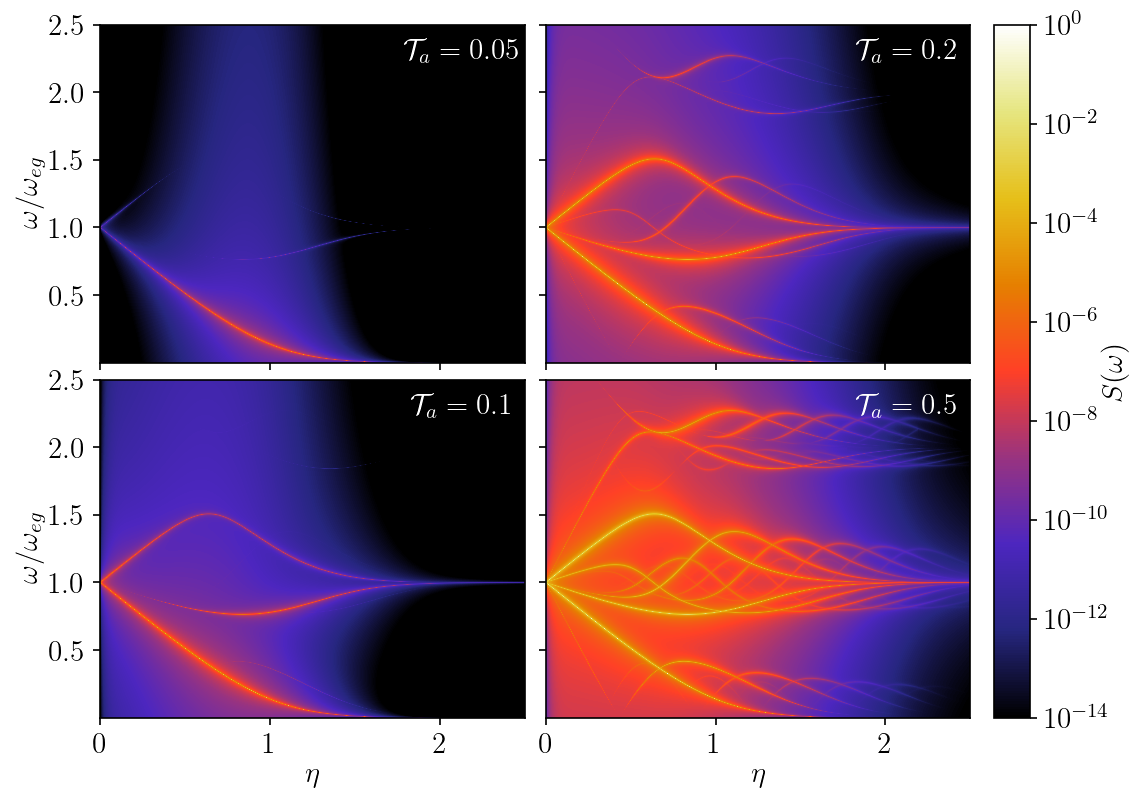

"/home/alberto/"

In [66]:
fig, axs = plt.subplots(2,2,sharex=true,sharey=true,dpi = 150, figsize = (8, 6), gridspec_kw=Dict("hspace"=>0.05, "wspace"=>0.05))

# log norm
vmin = 1e-14
my_norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=1)
idxs = findall(x -> x <= vmin, res_spectrum_T1)
res_spectrum_T1[idxs] .= vmin
idxs = findall(x -> x <= vmin, res_spectrum_T2)
res_spectrum_T2[idxs] .= vmin
idxs = findall(x -> x <= vmin, res_spectrum_T3)
res_spectrum_T3[idxs] .= vmin
idxs = findall(x -> x <= vmin, res_spectrum_T4)
res_spectrum_T4[idxs] .= vmin

extent = [η_list[1], η_list[end], ω_list[1], ω_list[end]]

ax = axs[1]
img = ax.pcolormesh(η_list, ω_list, res_spectrum_T1, shading="auto", cmap="CMRmap", rasterized=true, norm=my_norm)
# img = ax.imshow(res_spectrum_T1, extent=extent, origin="lower", cmap="CMRmap", norm=my_norm, aspect="auto", interpolation="gaussian")
ax.set_ylabel(raw"$\omega / \omega_{eg}$")
ax.set_xlim(0, η_list[end])
ax.set_ylim(ω_list[1], ω_list[end])
# ax.xaxis.set_major_locator(MultipleLocator(1))
ax.text(0.85, 0.9, raw"$\mathcal{T}_a = " * string(T1) * raw"$", transform=ax.transAxes, ha="center", color = "white")

ax = axs[2]
img = ax.pcolormesh(η_list, ω_list, res_spectrum_T2, shading="auto", cmap="CMRmap", rasterized=true, norm=my_norm)
# img = ax.imshow(res_spectrum_T2, extent=extent, origin="lower", cmap="CMRmap", norm=my_norm, aspect="auto", interpolation="gaussian")
ax.set_xlabel(raw"$\eta$")
ax.set_ylabel(raw"$\omega / \omega_{eg}$")
ax.text(0.85, 0.9, raw"$\mathcal{T}_a = " * string(T2) * raw"$", transform=ax.transAxes, ha="center", color = "white")

ax = axs[3]
img = ax.pcolormesh(η_list, ω_list, res_spectrum_T3, shading="auto", cmap="CMRmap", rasterized=true, norm=my_norm)
# img = ax.imshow(res_spectrum_T3, extent=extent, origin="lower", cmap="CMRmap", norm=my_norm, aspect="auto", interpolation="gaussian")
ax.text(0.85, 0.9, raw"$\mathcal{T}_a = " * string(T3) * raw"$", transform=ax.transAxes, ha="center", color = "white")

ax = axs[4]
img = ax.pcolormesh(η_list, ω_list, res_spectrum_T4, shading="auto", cmap="CMRmap", rasterized=true, norm=my_norm)
# img = ax.imshow(res_spectrum_T4, extent=extent, origin="lower", cmap="CMRmap", norm=my_norm, aspect="auto", interpolation="gaussian")
ax.set_xlabel(raw"$\eta$")
ax.text(0.85, 0.9, raw"$\mathcal{T}_a = " * string(T4) * raw"$", transform=ax.transAxes, ha="center", color = "white")

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.11, 0.03, 0.77])
colbar = fig.colorbar(img, cax=cbar_ax)
colbar.set_label(raw"$S (\omega)$", labelpad=-5)

root_dir = "/home/alberto/"
# root_dir = "/mnt/c/Users/alber/"
# plt.savefig(root_dir * "OneDrive/GitHub/Latex-Projects/phd-thesis/figures/cavity_spectrum_vs_eta_usc_dsc.pdf", dpi=300, bbox_inches="tight")

Single spectra with fixed $\eta$

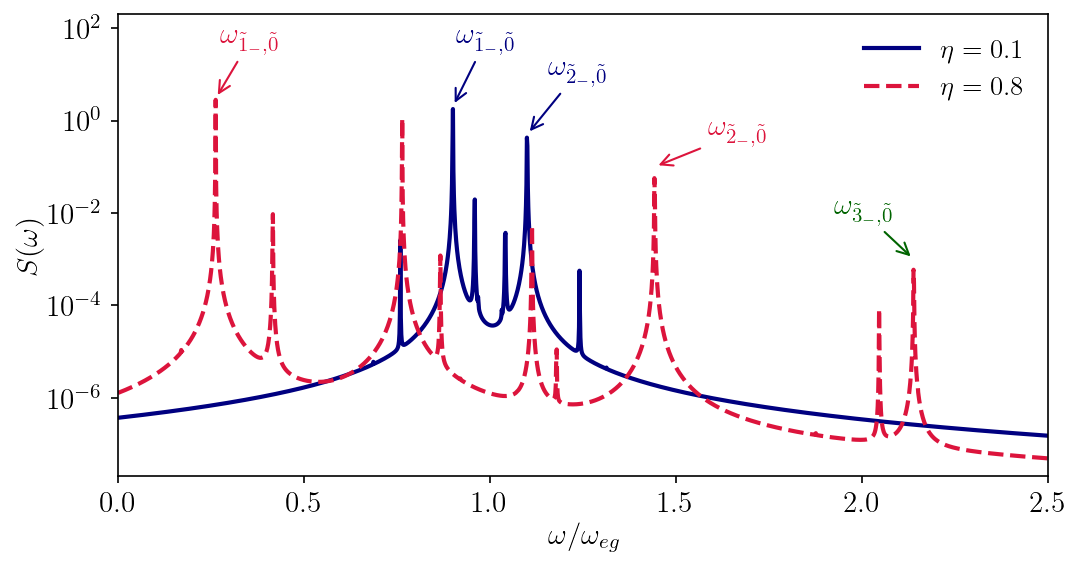

In [76]:
ωc = 1
ωeg = 1
κc = 1e-4
κa = 1e-4
N_trunc = 15
tol = 1e-15

η1 = 0.1
η2 = 0.8
T = 0.2

ω_list = range(1e-6, 2.5, 2000)

vals_η1 = freq_transitions(η1)
ω10_η1 = vals_η1[2] - vals_η1[1]
ω20_η1 = vals_η1[3] - vals_η1[1]

vals_η2 = freq_transitions(η2)
ω10_η2 = vals_η2[2] - vals_η2[1]
ω20_η2 = vals_η2[3] - vals_η2[1]
ω50_η2 = vals_η2[6] - vals_η2[1]

spec1 = cavity_spectrum(ω_list, η1, T)
spec2 = cavity_spectrum(ω_list, η2, T)

fig, ax = plt.subplots(dpi = 150, figsize = (8, 4))

ax.plot(ω_list, spec1, color="navy", lw=2, label=raw"$\eta = " * string(η1) * raw"$")
ax.plot(ω_list, spec2, color="crimson", lw=2, ls="--", label=raw"$\eta = " * string(η2) * raw"$")
# show an arrow per each peak position, following the eigenvalues 
ax.annotate(raw"$\omega_{\tilde{1}_-,\tilde{0}}$", xy=(ω10_η1, 2), xytext=(1.01*ω10_η1, 50), color="navy", arrowprops=Dict("arrowstyle"=>"->", "color"=>"navy"))
ax.annotate(raw"$\omega_{\tilde{2}_-,\tilde{0}}$", xy=(ω20_η1, 0.5), xytext=(1.05*ω20_η1, 10), color="navy", arrowprops=Dict("arrowstyle"=>"->", "color"=>"navy"))
ax.annotate(raw"$\omega_{\tilde{1}_-,\tilde{0}}$", xy=(ω10_η2, 3), xytext=(1.05*ω10_η2, 50), color="crimson", arrowprops=Dict("arrowstyle"=>"->", "color"=>"crimson"))
ax.annotate(raw"$\omega_{\tilde{2}_-,\tilde{0}}$", xy=(ω20_η2, 0.1), xytext=(1.1*ω20_η2, 0.5), color="crimson", arrowprops=Dict("arrowstyle"=>"->", "color"=>"crimson"))
ax.annotate(raw"$\omega_{\tilde{3}_-,\tilde{0}}$", xy=(ω50_η2, 1e-3), xytext=(0.9*ω50_η2, 1e-2), color="darkgreen", arrowprops=Dict("arrowstyle"=>"->", "color"=>"darkgreen"))
ax.set_xlabel(raw"$\omega / \omega_{eg}$")
ax.set_ylabel(raw"$S(\omega)$")
ax.set_yscale("log")
ax.set_xlim(0, ω_list[end])
ax.set_ylim(nothing, 2e2)
ax.legend()

root_dir = "/home/alberto/"
# root_dir = "/mnt/c/Users/alber/"
# plt.savefig(root_dir * "OneDrive/GitHub/Latex-Projects/phd-thesis/figures/cavity_spectrum_vs_omega_eta_01_08.pdf", dpi=300, bbox_inches="tight")

### Positive detuning

#### Possible transitions as a function of $\eta$

In [77]:
ωc = 1.3
ωeg = 1

function optim_objective(η, i, j)
    H_op = H_D(ωc, ωeg, η)

    E = eigs(H_op.data, nev=6, sigma=-2)[1]
    abs2(E[i] - E[j])
end

result = optimize(η -> optim_objective(η, 4, 3), 0.1, 0.7)
eta_inversion_2_3 = result.minimizer[1]
result = optimize(η -> optim_objective(η, 6, 5), 0.1, 0.7)
eta_inversion_4_5_1 = result.minimizer[1]
result = optimize(η -> optim_objective(η, 6, 5), 0.7, 1.3)
eta_inversion_4_5_2 = result.minimizer[1]

function freq_transitions(η)
    H_op = H_D(ωc, ωeg, η)

    E = eigs(H_op.data, nev=6, sigma=-2)[1]
    E = real.(E .- E[1])
    if η > eta_inversion_2_3
        E[3], E[4] = E[4], E[3]
    end
    if η > eta_inversion_4_5_1
        E[5], E[6] = E[6], E[5]
    end
    if η > eta_inversion_4_5_2
        E[5], E[6] = E[6], E[5]
    end

    return E
end

freq_transitions (generic function with 1 method)

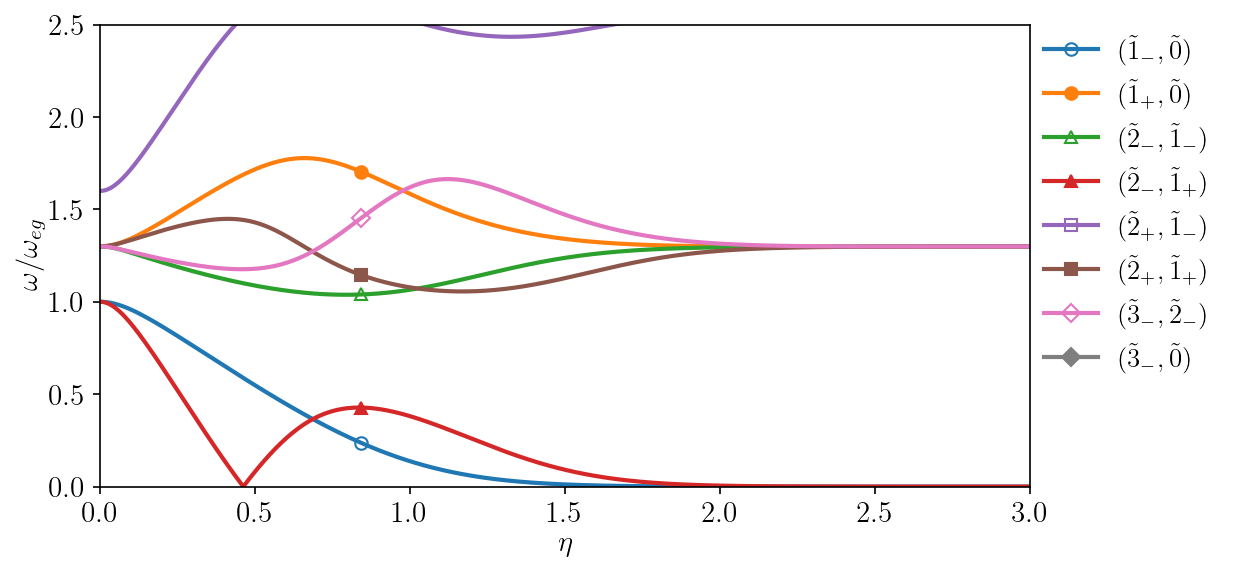

PyObject <matplotlib.legend.Legend object at 0x7f4882f76750>

In [78]:
η_list = range(0, 3, 500)
values = freq_transitions.(η_list)
values = hcat(values...)

fig, ax = plt.subplots(dpi = 150, figsize = (8, 4))

eigvect_notation = [raw"\tilde{0}", raw"\tilde{1}_{-}", raw"\tilde{1}_{+}", raw"\tilde{2}_{-}", raw"\tilde{2}_{+}", raw"\tilde{3}_{-}", raw"\tilde{3}_{+}"]

markers = ["o", "^", "s", "D", "X"]

j = 1
i = 0
ax.plot(η_list, abs.(values[j+1,:] - values[i+1,:]), label = raw"$(" * (eigvect_notation[j+1]) * raw", " * (eigvect_notation[i+1]) * raw")$", lw = 2, 
           marker = "o", markevery = [floor(Int, 0.28 * length(η_list))], markerfacecolor="none")
j = 2
i = 0
ax.plot(η_list, abs.(values[j+1,:] - values[i+1,:]), label = raw"$(" * (eigvect_notation[j+1]) * raw", " * (eigvect_notation[i+1]) * raw")$", lw = 2, 
           marker = "o", markevery = [floor(Int, 0.28 * length(η_list))])
j = 3
i = 1
ax.plot(η_list, abs.(values[j+1,:] - values[i+1,:]), label = raw"$(" * (eigvect_notation[j+1]) * raw", " * (eigvect_notation[i+1]) * raw")$", lw = 2, 
           marker = "^", markevery = [floor(Int, 0.28 * length(η_list))], markerfacecolor="none")
j = 3
i = 2
ax.plot(η_list, abs.(values[j+1,:] - values[i+1,:]), label = raw"$(" * (eigvect_notation[j+1]) * raw", " * (eigvect_notation[i+1]) * raw")$", lw = 2, 
           marker = "^", markevery = [floor(Int, 0.28 * length(η_list))])
j = 4
i = 1
ax.plot(η_list, abs.(values[j+1,:] - values[i+1,:]), label = raw"$(" * (eigvect_notation[j+1]) * raw", " * (eigvect_notation[i+1]) * raw")$", lw = 2, 
           marker = "s", markevery = [floor(Int, 0.28 * length(η_list))], markerfacecolor="none")
j = 4
i = 2
ax.plot(η_list, abs.(values[j+1,:] - values[i+1,:]), label = raw"$(" * (eigvect_notation[j+1]) * raw", " * (eigvect_notation[i+1]) * raw")$", lw = 2, 
           marker = "s", markevery = [floor(Int, 0.28 * length(η_list))])
j = 5
i = 3
ax.plot(η_list, abs.(values[j+1,:] - values[i+1,:]), label = raw"$(" * (eigvect_notation[j+1]) * raw", " * (eigvect_notation[i+1]) * raw")$", lw = 2, 
           marker = "D", markevery = [floor(Int, 0.28 * length(η_list))], markerfacecolor="none")
j = 5
i = 0
ax.plot(η_list, abs.(values[j+1,:] - values[i+1,:]), label = raw"$(" * (eigvect_notation[j+1]) * raw", " * (eigvect_notation[i+1]) * raw")$", lw = 2, 
           marker = "D", markevery = [floor(Int, 0.28 * length(η_list))])

ax.set_xlabel(raw"$\eta$")
ax.set_ylabel(raw"$\omega / \omega_{eg}$")
ax.set_xlim(η_list[1], η_list[end])
ax.set_ylim(0, 2.5)
ax.legend(bbox_to_anchor=(1.22, 1.03), loc="upper right")

# plt.savefig("/mnt/c/Users/alber/OneDrive/GitHub/Latex-Projects/phd-thesis/figures/freq_transitions_vs_eta_detuned.pdf", dpi=300, bbox_inches="tight")


#### Emission spectrum

Weak and strong coupling regimes and comparison with the dressed master equation

In [20]:
ωc = 1.3
ωeg = 1
κc = 1e-3
κa = 1e-4
N_trunc = 10
tol = 1e-15

η_list_weak = geomspace(1e-3, 2e-2, 1000)
η_list_usc = range(1e-6, 2, 1000)
ω_list_weak = range(0.998, 1.002, 2000)
ω_list_usc = range(1e-6, 2, 2000)
T = 0.05

res_spectrum_weak = similar(η_list_weak, length(ω_list_weak), length(η_list_weak))
res_spectrum_usc = similar(η_list_usc, length(ω_list_usc), length(η_list_usc))

pr = Progress(length(η_list_weak), showspeed=true)
Threads.@threads for i in eachindex(η_list_weak)
    res_spectrum_weak[:, i] = cavity_spectrum(ω_list_weak, η_list_weak[i], T)
    next!(pr)
end
res_spectrum_weak ./= maximum(res_spectrum_weak)

pr = Progress(length(η_list_usc), showspeed=true)
Threads.@threads for i in eachindex(η_list_usc)
    res_spectrum_usc[:, i] = cavity_spectrum(ω_list_usc, η_list_usc[i], T)
    next!(pr)
end
res_spectrum_usc ./= maximum(res_spectrum_usc);

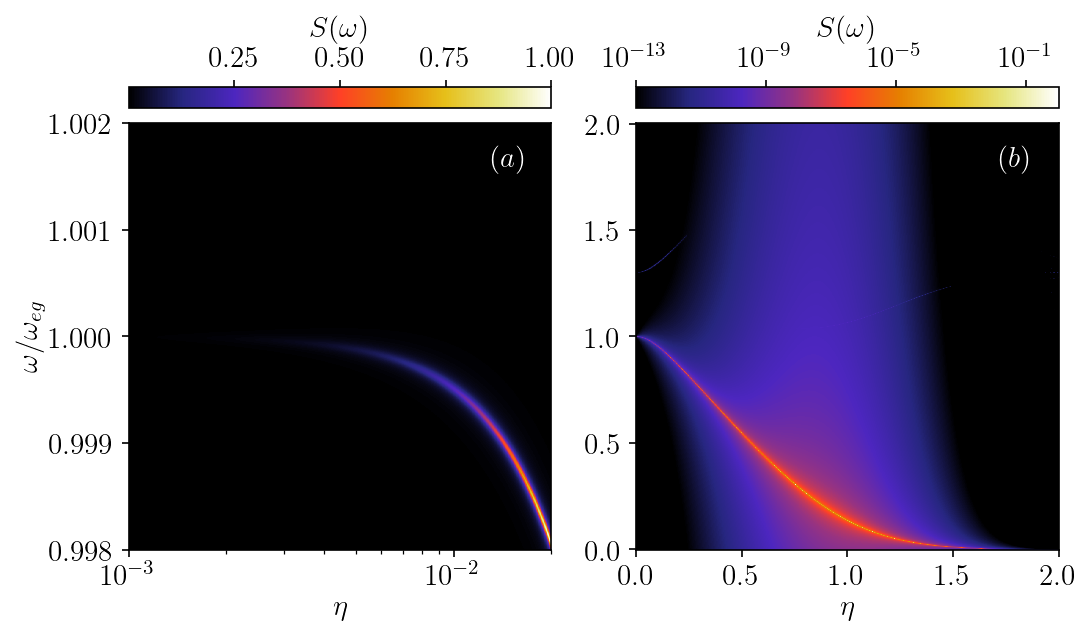

In [22]:
fig, axs = plt.subplots(1, 2, sharey=false, dpi = 150, figsize = (8, 4.5))

# log norm
vmin = 1e-13
my_norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=1)
idxs = findall(x -> x <= vmin, res_spectrum_usc)
res_spectrum_usc[idxs] .= vmin

ax = axs[1]
img1 = ax.pcolormesh(η_list_weak, ω_list_weak, res_spectrum_weak, shading="auto", cmap="CMRmap", rasterized=true)
ax.set_xlabel(raw"$\eta$")
ax.set_ylabel(raw"$\omega / \omega_{eg}$")
ax.set_xlim(η_list_weak[1], η_list_weak[end])
ax.set_ylim(ω_list_weak[1], ω_list_weak[end])
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.001))
ax.set_xscale("log")
ax.text(0.9, 0.9, raw"$(a)$", transform=ax.transAxes, ha="center", color = "white")

ax = axs[2]
img2 = ax.pcolormesh(η_list_usc, ω_list_usc, res_spectrum_usc, shading="auto", cmap="CMRmap", rasterized=true, norm=my_norm)
ax.set_xlabel(raw"$\eta$")
ax.set_xlim(0, η_list_usc[end])
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.text(0.9, 0.9, raw"$(b)$", transform=ax.transAxes, ha="center", color = "white")

colbar1 = fig.colorbar(img1, ax=axs[1], orientation = "horizontal", location="top", pad=0.03)
colbar1.set_label(raw"$S(\omega)$", labelpad=5)

colbar2 = fig.colorbar(img2, ax=axs[2], orientation = "horizontal", location="top", pad=0.03)
colbar2.set_label(raw"$S(\omega)$", labelpad=5)

root_dir = "/home/alberto/"
# root_dir = "/mnt/c/Users/alber/"
# plt.savefig(root_dir * "OneDrive/GitHub/Latex-Projects/phd-thesis/figures/cavity_spectrum_vs_eta_weak_strong_detuned.pdf", dpi=300, bbox_inches="tight")

## Comparison of emission spectrum with other models

### Weak coupling dressed me

In [82]:
ωc = 1
ωeg = 1
κc = 1e-3
κa = 1e-4
N_trunc = 10
tol = 1e-15

η_list = geomspace(1e-6, 5e-2, 2000)
ω_list = range(0.96*1, 1.04*1, 5000)
T = 0.05

res_spectrum = similar(η_list, length(ω_list), length(η_list))
res_spectrum_dr = similar(η_list, length(ω_list), length(η_list))
pr = Progress(length(η_list), showspeed=true)

Threads.@threads for i in eachindex(η_list)
    res_spectrum[:, i] = cavity_spectrum(ω_list, η_list[i], T)
    res_spectrum_dr[:, i] = cavity_spectrum_dressed(ω_list, η_list[i], T)
    next!(pr)
end
res_spectrum_dr ./= maximum(res_spectrum)
res_spectrum ./= maximum(res_spectrum);

Progress: 100%|███████████████████████████| Time: 0:00:11 ( 5.58 ms/it)


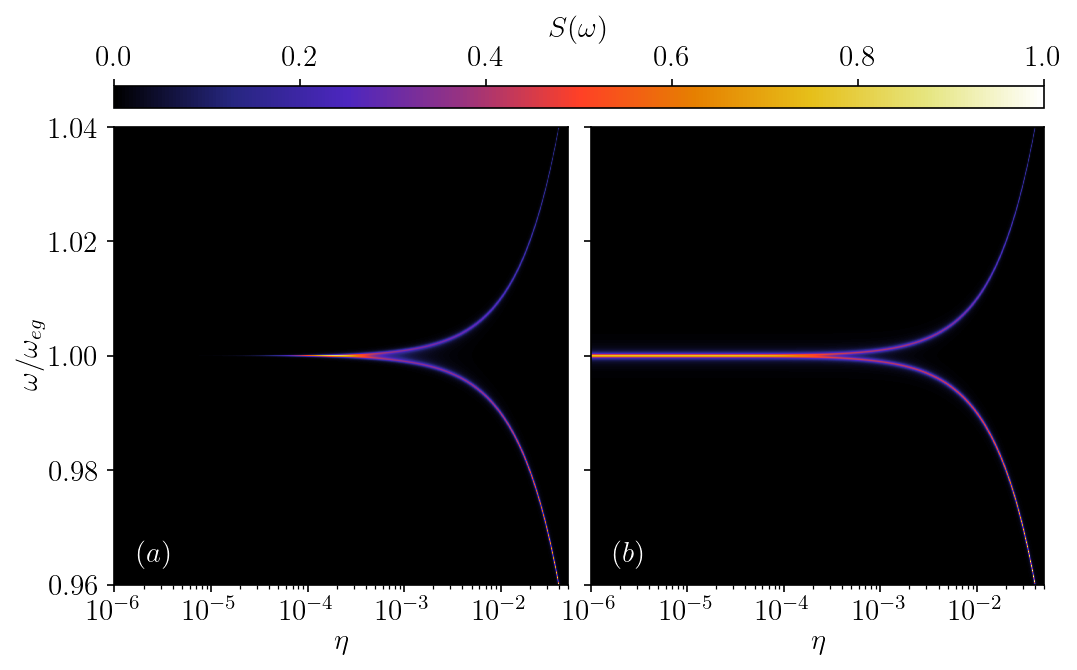

"/home/alberto/"

In [83]:
fig, axs = plt.subplots(1, 2, sharey=true, dpi = 150, figsize = (8, 5), gridspec_kw=Dict("hspace"=>0.05, "wspace"=>0.05))

ax = axs[1]
img1 = ax.pcolormesh(η_list, ω_list, res_spectrum, shading="auto", cmap="CMRmap", rasterized=true)
ax.set_xlabel(raw"$\eta$")
ax.set_ylabel(raw"$\omega / \omega_{eg}$")
ax.set_xlim(η_list[1], η_list[end])
ax.set_ylim(ω_list[1], ω_list[end])
ax.set_xscale("log")
ax.text(0.05, 0.05, raw"$(a)$", transform=ax.transAxes, color = "white")

ax = axs[2]
img2 = ax.pcolormesh(η_list, ω_list, res_spectrum_dr, shading="auto", cmap="CMRmap", rasterized=true)
ax.set_xlabel(raw"$\eta$")
ax.set_xlim(η_list[1], η_list[end])
ax.set_xscale("log")
ax.text(0.05, 0.05, raw"$(b)$", transform=ax.transAxes, color = "white")

fig.subplots_adjust(top = 0.72)
cbar_ax = fig.add_axes([0.125, 0.745, 0.775, 0.03])
colbar = fig.colorbar(img1, cax=cbar_ax, orientation = "horizontal")
colbar.set_label(raw"$S(\omega)$", labelpad=-45)
cbar_ax.xaxis.set_ticks_position("top")

root_dir = "/home/alberto/"
# root_dir = "/mnt/c/Users/alber/"
# plt.savefig(root_dir * "OneDrive/GitHub/Latex-Projects/phd-thesis/figures/cavity_spectrum_vs_eta_gme_dr.pdf", dpi=300, bbox_inches="tight")

### USC with Jaynes Cummings and standard master equation

In [16]:
ωc = 1
ωeg = 1
κc = 1e-3
κa = 1e-4
N_trunc = 22
tol = 1e-15

η_list = range(1e-6, 2.5, 1000)
ω_list = range(1e-6, 2.5, 1000)
T = 0.2

res_spectrum = similar(η_list, length(ω_list), length(η_list))
res_spectrum_JC = similar(η_list, length(ω_list), length(η_list))

pr = Progress(length(η_list), showspeed=true)

Threads.@threads for i in eachindex(η_list)
    res_spectrum[:, i] = cavity_spectrum(ω_list, η_list[i], T)
    res_spectrum_JC[:, i] = cavity_spectrum_wrong2(ω_list, η_list[i], T)
    next!(pr)
end
res_spectrum_JC ./= maximum(res_spectrum)
res_spectrum ./= maximum(res_spectrum);

Progress: 100%|███████████████████████████| Time: 0:00:21 (21.69 ms/it)


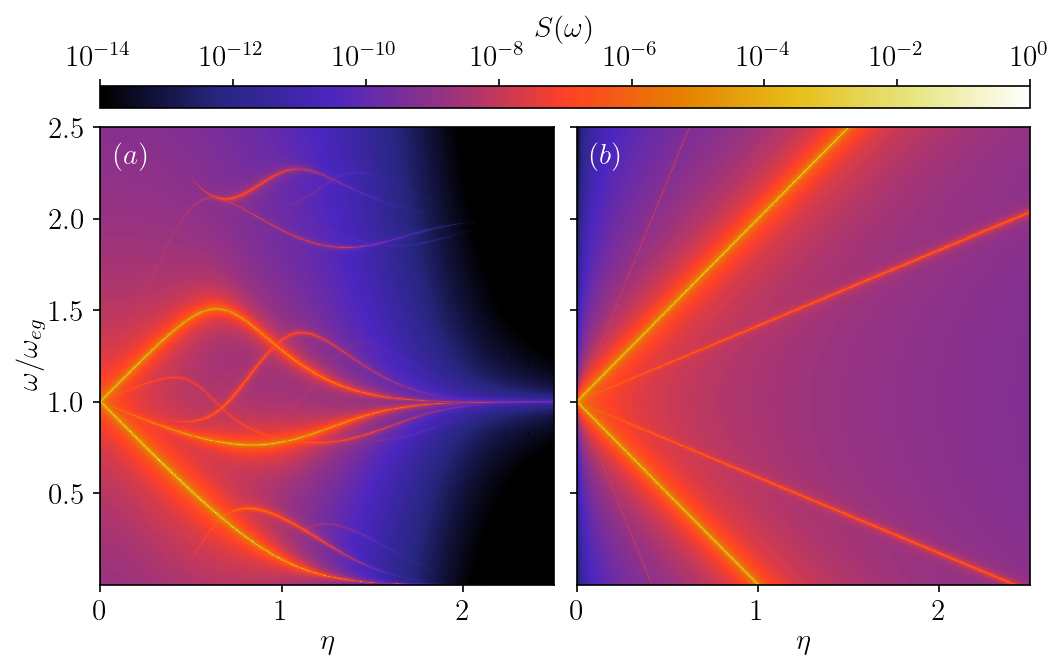

In [21]:
fig, axs = plt.subplots(1, 2, sharey=true, dpi = 150, figsize = (8, 5), gridspec_kw=Dict("hspace"=>0.05, "wspace"=>0.05))

# log norm
vmin = 1e-14
my_norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=1)

extent = [η_list[1], η_list[end], ω_list[1], ω_list[end]]

ax = axs[1]
img = ax.pcolormesh(η_list, ω_list, res_spectrum, shading="auto", cmap="CMRmap", rasterized=true, norm=my_norm)
# img = ax.imshow(res_spectrum_T1, extent=extent, origin="lower", cmap="CMRmap", norm=my_norm, aspect="auto", interpolation="gaussian")
ax.set_xlabel(raw"$\eta$")
ax.set_ylabel(raw"$\omega / \omega_{eg}$")
# ax.set_xlim(0, η_list[end])
ax.set_ylim(ω_list[1], ω_list[end])
ax.text(0.03, 0.92, raw"$(a)$", transform=ax.transAxes, color = "white")

ax = axs[2]
img = ax.pcolormesh(η_list, ω_list, res_spectrum_JC, shading="auto", cmap="CMRmap", rasterized=true, norm=my_norm)
# img = ax.imshow(res_spectrum_T3, extent=extent, origin="lower", cmap="CMRmap", norm=my_norm, aspect="auto", interpolation="gaussian")
ax.set_xlabel(raw"$\eta$")
ax.text(0.03, 0.92, raw"$(b)$", transform=ax.transAxes, color = "white")

fig.subplots_adjust(top = 0.72)
cbar_ax = fig.add_axes([0.125, 0.745, 0.775, 0.03])
colbar = fig.colorbar(img, cax=cbar_ax, orientation = "horizontal")
colbar.set_label(raw"$S(\omega)$", labelpad=-45)
cbar_ax.xaxis.set_ticks_position("top")

root_dir = "/home/alberto/"
# root_dir = "/mnt/c/Users/alber/"
# plt.savefig(root_dir * "OneDrive/GitHub/Latex-Projects/phd-thesis/figures/cavity_spectrum_vs_eta_weak_gme_jc.pdf", dpi=300, bbox_inches="tight")

## Raman scattering

In [279]:
Nc = 35

a = kron(destroy(Nc), eye(2), eye(2))

σx = kron(eye(Nc), sigmax(), eye(2))
σy = kron(eye(Nc), sigmay(), eye(2))
σz = kron(eye(Nc), sigmaz(), eye(2))

σx_s = kron(eye(Nc), eye(2), sigmax())
σy_s = kron(eye(Nc), eye(2), sigmay())
σz_s = kron(eye(Nc), eye(2), sigmaz())

σp(θ) = cos(θ) * σx + sin(θ) * σz

H_D_sensor(ωc, ωeg, ωs, η, ηs, θ) = ωc * a'*a + ωeg/2 * σz + ωs/2 * σz_s - 1im*η*ωc*(a-a')*σp(θ) - ηs*ωc*( 1im*(a-a') - 2*η*σp(θ) ) * σx_s

function get_liouvillian_sensor(ωs, θ, η, T)
    H_op = H_D_sensor(ωc, ωeg, ωs, η, ηs, θ)
    fields = [sqrt(κc)*( 1im*(a-a') - 2*η*σp(θ) ), sqrt(κa)*σp(θ), sqrt(κs/ωs)*σx_s]
    T_list = [T, T, 0]

    liouvillian_generalized(H_op, fields, T_list, N_trunc=N_trunc, tol=tol, σ_filter=100*(κc))
end

function sensor_population(ωd, ωs, Ad, θ, η, E, U, L)
    Ω = dense_to_sparse(E' .- E, tol)

    X_op = dense_to_sparse( (U' * ( 1im*(a-a') - 2*η*σp(θ) ) * U)[1:N_trunc,1:N_trunc], tol)
    X_op = QuantumObject(X_op)
    Xp = triu(X_op, 1)

    Σ_s = dense_to_sparse( (Ω ./ ωs) .* (U' * σx_s * U)[1:N_trunc,1:N_trunc], tol)
    Σ_s = QuantumObject(Σ_s)
    Σp_s = triu(Σ_s, 1)

    H_t = Ad/2 * X_op

    ρss = steadystate_floquet(L, [], H_t, H_t, ωd, n_max=4, lf_solver=LiouvillianDirectSolver(tol=tol^2))
    expect(Σp_s' * Σp_s, ρss)
end

sensor_population (generic function with 1 method)

In [274]:
ωc = 1
ωeg = 1
η = 0.3
θ = π/6
ηs = 1e-5
Ad = 5e-3
κc = 1e-3
κa = 1e-3
κs = 1e-3
T = 0.0
tol = 1e-15
N_trunc = 10

ωd = 1.1

ωs_list = range(1e-4, 1.3, 500)

res_spec = similar(ωs_list)

# sensor_population(ωc, ωs, Ad, θ, η, T)

pr = Progress(length(ωs_list), showspeed=true)
Threads.@threads for i in eachindex(ωs_list)
    # res_spec[i] = sensor_population(ωd, ωs_list[i], Ad, θ, η, T)
    # next!(pr)
    E, U, L = get_liouvillian_sensor(ωs_list[i], θ, η, T)
    res_spec[i] = sensor_population(ωd, ωs_list[i], Ad, θ, η, E, U, L)
    next!(pr)
end
# @. res_spec = abs(res_spec);

Progress: 100%|███████████████████████████| Time: 0:00:01 ( 3.35 ms/it)


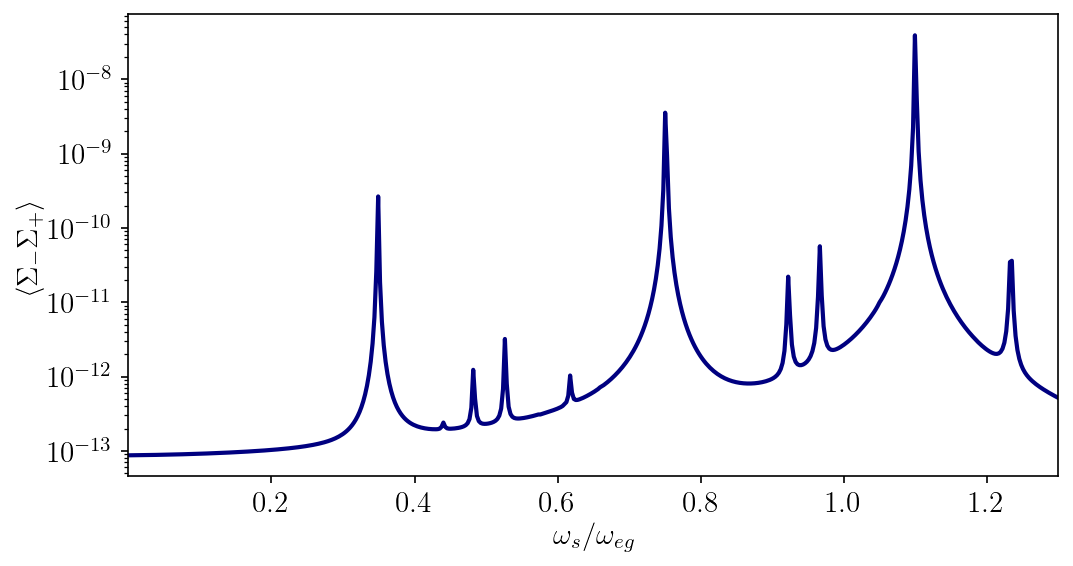

In [275]:
fig, ax = plt.subplots(dpi = 150, figsize = (8, 4))

ax.plot(ωs_list, res_spec, lw=2, color="navy")
ax.set_xlabel(raw"$\omega_s / \omega_{eg}$")
ax.set_ylabel(raw"$\langle \Sigma_- \Sigma_+ \rangle$")
ax.set_xlim(ωs_list[1], ωs_list[end])
# ax.set_ylim(1e-14, 1e-6)
ax.set_yscale("log")

### 2d Plot

In [14]:
# stderr_file = open("stderr.txt", "w+")
# redirect_stderr(stderr_file)

IOStream(<file stderr.txt>)

In [233]:
ωc = 1
ωeg = 1
η = 0.3
θ = π/6
ηs = 1e-5
Ad = 5e-3
κc = 1e-3
κa = 1e-3
κs = 1e-3
tol = 1e-15
N_trunc = 15

T1 = 0
T2 = 0.15

ωs_list = range(1e-6, 2.5, 1500)
ωd_list = range(1e-6, 3, 1500)

res_spec_T1 = similar(ωs_list, length(ωd_list), length(ωs_list))
res_spec_T2 = similar(ωs_list, length(ωd_list), length(ωs_list))

pr = Progress(length(ωs_list), showspeed=true)
Threads.@threads for i in eachindex(ωs_list)
    E1, U1, L1 = get_liouvillian_sensor(ωs_list[i], θ, η, T1)
    E2, U2, L2 = get_liouvillian_sensor(ωs_list[i], θ, η, T2)
    for j in eachindex(ωd_list)
        res_spec_T1[j, i] = sensor_population(ωd_list[j], ωs_list[i], Ad, θ, η, E1, U1, L1)
        res_spec_T2[j, i] = sensor_population(ωd_list[j], ωs_list[i], Ad, θ, η, E2, U2, L2)
    end
    next!(pr)
end
# @. res_spec = abs(res_spec);

Progress: 100%|███████████████████████████| Time: 0:07:01 ( 2.11  s/it)


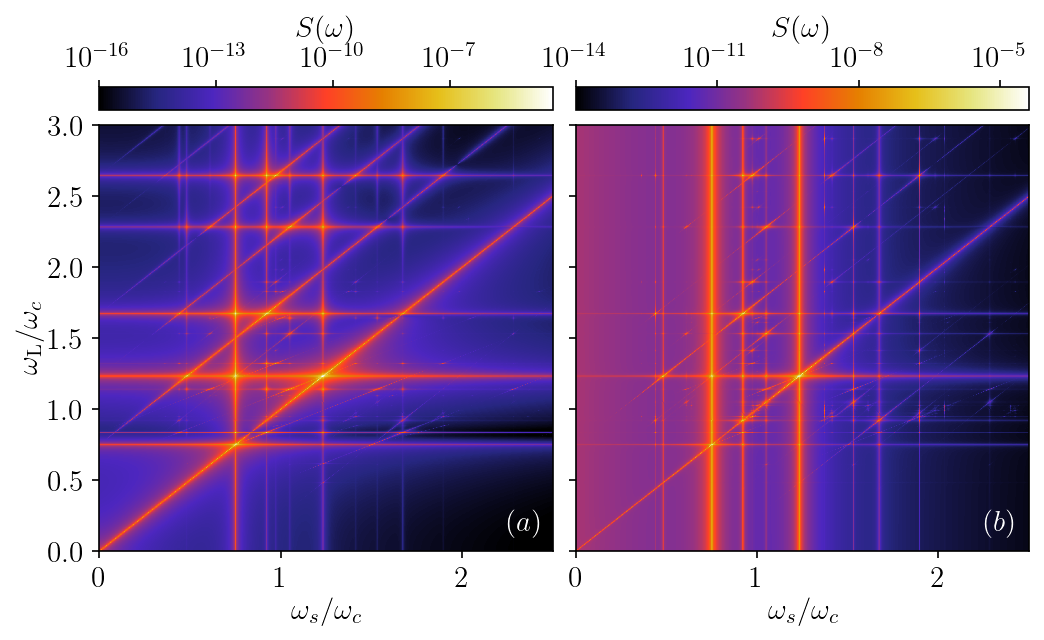

In [54]:
fig, axs = plt.subplots(1, 2, sharey=true, dpi = 150, figsize = (8, 4.5), gridspec_kw=Dict("hspace"=>0.05, "wspace"=>0.05))

# log norm
vmin1 = 1e-16
vmax1 = maximum(res_spec_T1)
my_norm1 = matplotlib.colors.LogNorm(vmin=vmin1, vmax=vmax1)
vmin2 = 1e-14
vmax2 = maximum(res_spec_T2)
my_norm2 = matplotlib.colors.LogNorm(vmin=vmin2, vmax=vmax2)

ax = axs[1]
img1 = ax.pcolormesh(ωs_list, ωd_list, res_spec_T1, shading="auto", cmap="CMRmap", rasterized=true, norm=my_norm1)
ax.set_xlabel(raw"$\omega_s / \omega_c$")
ax.set_ylabel(raw"$\omega_{\textrm{L}} / \omega_c$")
ax.text(0.9, 0.05, raw"$(a)$", transform=ax.transAxes, color = "white")

ax = axs[2]
img2 = ax.pcolormesh(ωs_list, ωd_list, res_spec_T2, shading="auto", cmap="CMRmap", rasterized=true, norm=my_norm2)
ax.set_xlabel(raw"$\omega_s / \omega_c$")
ax.text(0.9, 0.05, raw"$(b)$", transform=ax.transAxes, color = "white")

colbar1 = fig.colorbar(img1, ax=axs[1], orientation = "horizontal", location="top", pad=0.03)
colbar1.set_label(raw"$S(\omega)$", labelpad=5)

colbar2 = fig.colorbar(img2, ax=axs[2], orientation = "horizontal", location="top", pad=0.03)
colbar2.set_label(raw"$S(\omega)$", labelpad=5)

root_dir = "/home/alberto/"
# # root_dir = "/mnt/c/Users/alber/"
# plt.savefig(root_dir * "OneDrive/GitHub/Latex-Projects/phd-thesis/figures/raman_2d_spectrum.pdf", dpi=300, bbox_inches="tight")

### Possible transitions

In [5]:
a2 = kron(destroy(Nc), eye(2))

σx2 = kron(eye(Nc), sigmax())
σy2 = kron(eye(Nc), sigmay())
σz2 = kron(eye(Nc), sigmaz())

σp2(θ) = cos(θ) * σx2 + sin(θ) * σz2

H_D_sensor_Rabi(ωc, ωeg, η, θ) = ωc * a2'*a2 + ωeg/2 * σz2 - 1im*η*ωc*(a2-a2')*σp2(θ)

function freq_transitions(η, θ)
    H_op = H_D_sensor_Rabi(ωc, ωeg, η, θ)

    E = eigs(H_op.data, nev=6, sigma=-2)[1]
    E = real.(E .- E[1])

    return E
end

freq_transitions (generic function with 1 method)

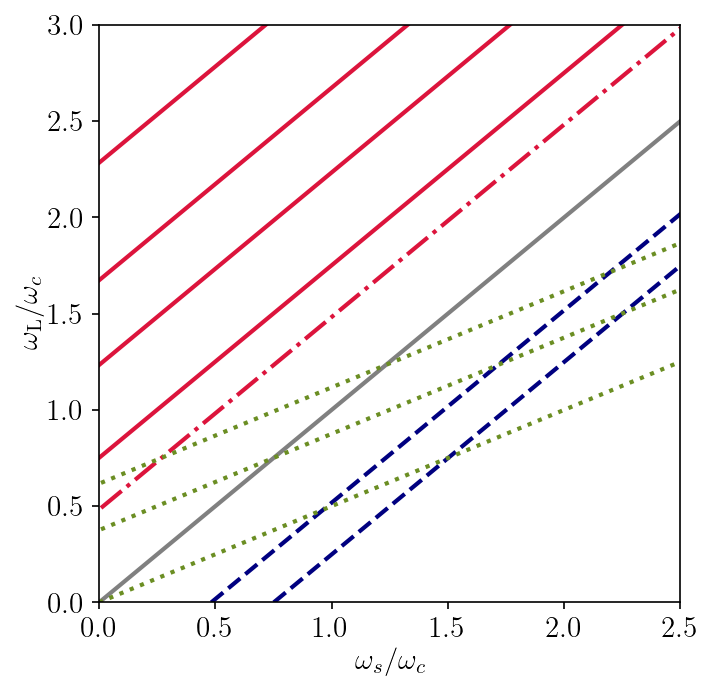

(0.0, 3.0)

In [6]:
ωc = 1
ωeg = 1
η = 0.3
θ = π/6

ωl_list = range(0, 3, 100)

ω_j0 = freq_transitions(η, θ)
ω_kj = ω_j0' .- ω_j0

fig, ax = plt.subplots(dpi = 150, figsize = (5, 5))

for i in 2:5
    ax.plot(ωl_list .- ω_kj[1,i], ωl_list, lw=2, color="crimson")
end
ax.plot(ωl_list .- ω_kj[2,3], ωl_list, lw=2, color="crimson", ls="-.")

ax.plot(ωl_list, ωl_list, lw=2, color="grey")

ax.plot(ωl_list .- ω_kj[2,1], ωl_list, lw=2, color="navy", ls="--")
ax.plot(ωl_list .- ω_kj[3,2], ωl_list, lw=2, color="navy", ls="--")

ax.plot(2*ωl_list .- ω_kj[1,1], ωl_list, lw=2, color="olivedrab", ls=":")
ax.plot(2*ωl_list .- ω_kj[1,2], ωl_list, lw=2, color="olivedrab", ls=":")
ax.plot(2*ωl_list .- ω_kj[1,3], ωl_list, lw=2, color="olivedrab", ls=":")

ax.set_xlabel(raw"$\omega_s / \omega_c$")
ax.set_ylabel(raw"$\omega_{\textrm{L}} / \omega_c$")
ax.set_xlim(0, 2.5)
ax.set_ylim(ωl_list[1], ωl_list[end])


### Perturbation Theory

In [149]:
function M_fi(ω, X, ωd, f, i)
    res = zero(X[1,1])
    for j in 1:size(X,1)
        res += X[j,f] * X[i,j] / ( ω[i,j] - ωd ) + X[j,f] * X[i,j] / ( ω[i,j] + ωd - ω[i,f] )
    end
    res
end

function get_liouvillian2(θ, η, T)
    H_op = H_D_sensor_Rabi(ωc, ωeg, η, θ)
    fields = [sqrt(κc)*( 1im*(a2-a2') - 2*η*σp2(θ) ), sqrt(κa)*σp2(θ)]
    T_list = [T, T]

    E, U, L = liouvillian_generalized(H_op, fields, T_list, N_trunc=N_trunc, tol=tol, σ_filter=100*(κc))
end

function raman_peak_pert_th(η, θ, ωd, T, f, i)
    E, U, L = get_liouvillian2(θ, η, T)

    ω_kj = E' .- E

    X_op = dense_to_sparse( (U' * ( 1im*(a2-a2') - 2*η*σp2(θ) ) * U)[1:N_trunc,1:N_trunc], tol)
    X_op = QuantumObject(X_op)
    Xp = triu(X_op, 1)

    H_t = Ad/2 * X_op #(Xp + Xp')

    ρss = steadystate_floquet(L, [], H_t, H_t, ωd, n_max=4, lf_solver=LiouvillianDirectSolver(tol=tol^2))

    return abs2(M_fi(ω_kj, X_op, ωd, f, i)) * ρss[i,i] * (1 - ρss[f,f])
end

function raman_peak_numerical(η, θ, ωd, T, f, i, n_ωs=50, σ=2)
    ω_j0 = eigvals(H_D_sensor_Rabi(ωc, ωeg, η, θ))[1:N_trunc]
    ω_kj = ω_j0' .- ω_j0
    ωs_list = range(ωd - ω_kj[i,f] - σ*κc, ωd - ω_kj[i,f] + σ*κc, n_ωs)

    res_spectrum = similar(ωs_list)
    for i in eachindex(ωs_list)
        E, U, L = get_liouvillian_sensor(ωs_list[i], θ, η, T)
        res_spectrum[i] = sensor_population(ωd, ωs_list[i], Ad, θ, η, E, U, L)
    end
    res_spectrum
end

raman_peak_numerical (generic function with 4 methods)

In [261]:
ωc = 1
ωeg = 1
η = 0.3
θ = π/6
ηs = 1e-5
Ad = 5e-3
κc = 1e-3
κa = 1e-3
κs = 1e-3
T = 0
N_trunc = 10
tol=1e-15

ωd = 1.1

# Figure 1
final_state = 2
initial_state = 1
η_list = geomspace(0.01, 0.3, 500)
res_pert_th = similar(η_list)
res_num = similar(η_list)
pr = Progress(length(η_list), showspeed=true)
Threads.@threads for i in eachindex(η_list)
    res_pert_th[i] = raman_peak_pert_th(η_list[i], θ, ωd, T, final_state, initial_state)
    res_num[i] = maximum(raman_peak_numerical(η_list[i], θ, ωd, T, final_state, initial_state))
    next!(pr)
end

# Figure 2
final_state = 2
initial_state = 1
η1, η2, η3 = 0.01, 0.05, 0.1
n_ωs = 100
stokes_peak_10 = zeros(Float64, n_ωs, 3)
stokes_peak_10[:,1] = raman_peak_numerical(η1, θ, ωd, T, final_state, initial_state, n_ωs, 3)
stokes_peak_10[:,2] = raman_peak_numerical(η2, θ, ωd, T, final_state, initial_state, n_ωs, 3)
stokes_peak_10[:,3] = raman_peak_numerical(η3, θ, ωd, T, final_state, initial_state, n_ωs, 3)

# Figure 3
ωd1 = 1.1
ωd2 = 2.1
final_state1 = 2
final_state2 = 4
initial_state = 1
θ_list = range(0, π, 500)
res_theta_pert_th1 = similar(θ_list)
res_theta_pert_th2 = similar(θ_list)
res_theta_num1 = similar(θ_list)
res_theta_num2 = similar(θ_list)
pr = Progress(length(θ_list), showspeed=true)
Threads.@threads for i in eachindex(θ_list)
    res_theta_pert_th1[i] = raman_peak_pert_th(η, θ_list[i], ωd1, T, final_state1, initial_state)
    res_theta_pert_th2[i] = raman_peak_pert_th(η, θ_list[i], ωd2, T, final_state2, initial_state)
    res_theta_num1[i] = maximum(raman_peak_numerical(η, θ_list[i], ωd1, T, final_state1, initial_state))
    res_theta_num2[i] = maximum(raman_peak_numerical(η, θ_list[i], ωd2, T, final_state2, initial_state))
    next!(pr)
end

# Figure 4
N_trunc = 15
tol=1e-40
T_list = range(0, 0.25, 300)
final_state = 2
initial_state = 1
res_temp_stokes_pert_th = similar(T_list)
res_temp_antistokes_pert_th = similar(T_list)
res_temp_stokes_num = similar(T_list)
res_temp_antistokes_num = similar(T_list)
pr = Progress(length(T_list), showspeed=true)
Threads.@threads for i in eachindex(T_list)
    res_temp_stokes_pert_th[i] = raman_peak_pert_th(η, θ, ωd, T_list[i], final_state, initial_state)
    res_temp_antistokes_pert_th[i] = raman_peak_pert_th(η, θ, ωd, T_list[i], initial_state, final_state)
    res_temp_stokes_num[i] = maximum(raman_peak_numerical(η, θ, ωd, T_list[i], final_state, initial_state))
    res_temp_antistokes_num[i] = maximum(raman_peak_numerical(η, θ, ωd, T_list[i], initial_state, final_state))
    next!(pr)
end

Progress: 100%|███████████████████████████| Time: 0:00:16 ( 0.17  s/it)
Progress: 100%|███████████████████████████| Time: 0:00:34 ( 0.35  s/it)
Progress: 100%|███████████████████████████| Time: 0:02:53 ( 1.73  s/it)


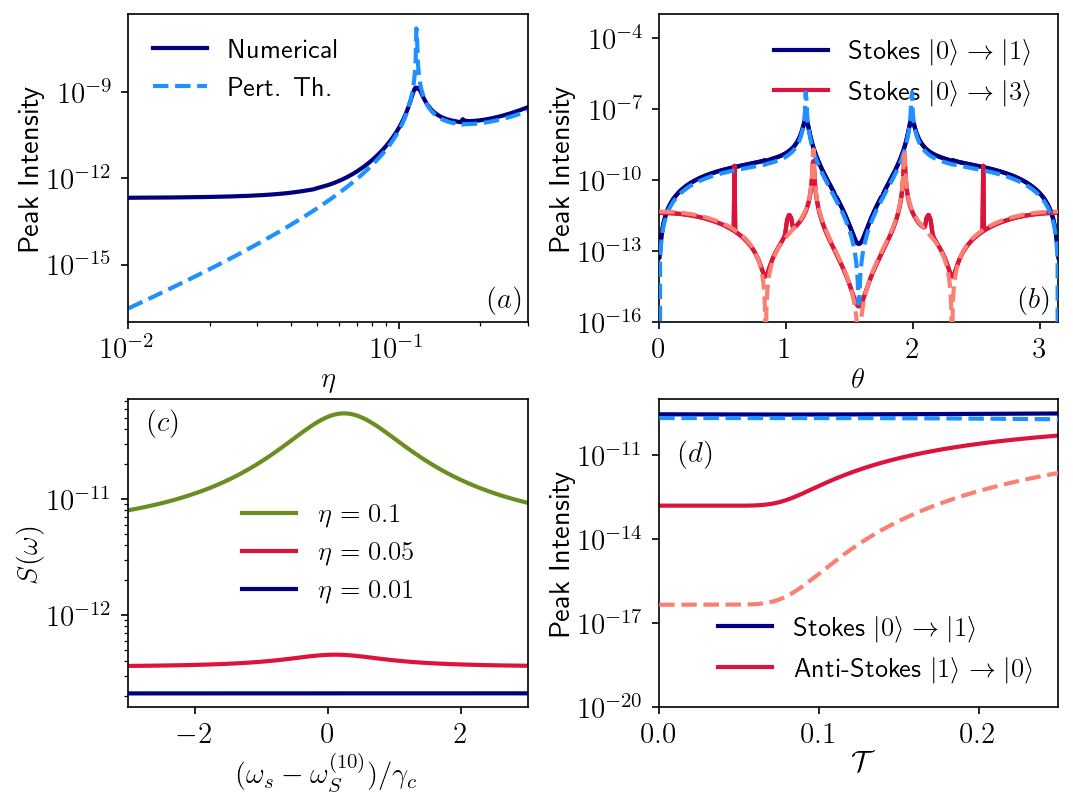

In [165]:
fig, axs = plt.subplots(2, 2, dpi = 150, figsize = (8, 6), gridspec_kw=Dict("hspace"=>0.25, "wspace"=>0.33))

factor = 2 * (Ad/2)^2 * (ηs * ωc)^2 / κs^2
# factor = (res_num[end] / res_pert_th[end])

ax = axs[1]
ax.plot(η_list, res_num, lw=2, color="navy", label="Numerical")
ax.plot(η_list, res_pert_th .* factor, lw=2, color="dodgerblue", ls="--", label="Pert. Th.")
ax.set_xlabel(raw"$\eta$")
ax.set_ylabel(raw"Peak Intensity")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(η_list[1], η_list[end])
ax.text(0.9, 0.05, raw"$(a)$", transform=ax.transAxes, color = "black")
ax.legend()

ax = axs[2]
ω_list = range(-3, 3, n_ωs)
ax.plot(ω_list, stokes_peak_10[:,3], lw=2, color="olivedrab", label=raw"$\eta = 0.1$")
ax.plot(ω_list, stokes_peak_10[:,2], lw=2, color="crimson", label=raw"$\eta = 0.05$")
ax.plot(ω_list, stokes_peak_10[:,1], lw=2, color="navy", label=raw"$\eta = 0.01$")
ax.set_xlabel(raw"$(\omega_s - \omega_S^{(10)}) / \gamma_c$")
ax.set_ylabel(raw"$S(\omega)$")
# ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(ω_list[1], ω_list[end])
ax.text(0.05, 0.9, raw"$(c)$", transform=ax.transAxes, color = "black")
ax.legend()

ax = axs[3]
ax.plot(θ_list, res_theta_num1, lw=2, color="navy", label=raw"Stokes $\ket{0} \to \ket{1}$")
ax.plot(θ_list, res_theta_pert_th1 .* factor,
        lw=2, color="dodgerblue", ls="--", zorder=10)
ax.plot(θ_list, res_theta_num2, lw=2, color="crimson", label=raw"Stokes $\ket{0} \to \ket{3}$")
ax.plot(θ_list, res_theta_pert_th2 .* factor,
        lw=2, color="salmon", ls="--", zorder=11)
ax.set_xlabel(raw"$\theta$")
ax.set_ylabel(raw"Peak Intensity")
ax.set_ylim(1e-16, 1e-3)
ax.set_yscale("log")
ax.set_xlim(θ_list[1], θ_list[end])
ax.text(0.9, 0.05, raw"$(b)$", transform=ax.transAxes, color = "black")
ax.legend()

ax = axs[4]
ax.plot(T_list, res_temp_stokes_num, lw=2, color="navy", label=raw"Stokes $\ket{0} \to \ket{1}$")
ax.plot(T_list, res_temp_stokes_pert_th .* factor,
        lw=2, color="dodgerblue", ls="--", zorder=10)
ax.plot(T_list, res_temp_antistokes_num, lw=2, color="crimson", label=raw"Anti-Stokes $\ket{1} \to \ket{0}$")
ax.plot(T_list, res_temp_antistokes_pert_th .* factor,
        lw=2, color="salmon", ls="--", zorder=11)
ax.set_xlabel(raw"$\mathcal{T}$")
ax.set_ylabel(raw"Peak Intensity")
ax.set_ylim(1e-20, 1e-9)
ax.set_yscale("log")
ax.set_xlim(T_list[1], T_list[end])
ax.text(0.05, 0.8, raw"$(d)$", transform=ax.transAxes, color = "black")
ax.legend()

ax = axs[3]
ax.plot(θ_list, res_theta_num1, lw=2, color="navy", label=raw"Stokes $\ket{0} \to \ket{1}$")
ax.plot(θ_list, res_theta_num2, lw=2, color="crimson", label=raw"Stokes $\ket{0} \to \ket{3}$")

root_dir = "/home/alberto/"
# root_dir = "/mnt/c/Users/alber/"
# plt.savefig(root_dir * "OneDrive/GitHub/Latex-Projects/phd-thesis/figures/raman_pert_th.pdf", dpi=300, bbox_inches="tight")

### Fisher information

In [289]:
ωc = 1
ωeg = 1
θ = π/6
ηs = 1e-5
Ad = 5e-3
κc = 1e-3
κa = 1e-3
κs = 1e-3
T = 0
N_trunc = 10
tol=1e-15

ωd = 1.1

δη = 0.0005
η1 = 0.3
η2 = η1 + δη

σ_spec = 4
n_ωs = 500
ω_j0 = eigvals(H_D_sensor_Rabi(ωc, ωeg, η1, θ))
ω_j0 = ω_j0 .- ω_j0[1]
ωs_list_stokes = range(ωd - ω_j0[2] - σ_spec*κc, ωd - ω_j0[2] + σ_spec*κc, n_ωs)
ωs_list_direct = range(ω_j0[2] - σ_spec*κs, ω_j0[2] + σ_spec*κs, n_ωs)

res_spec_stokes1 = similar(ωs_list_stokes)
res_spec_direct1 = similar(ωs_list_direct)
res_spec_stokes2 = similar(ωs_list_stokes)
res_spec_direct2 = similar(ωs_list_direct)

pr = Progress(length(ωs_list_stokes), showspeed=true)
Threads.@threads for i in eachindex(ωs_list_stokes)
    E1, U1, L1 = get_liouvillian_sensor(ωs_list_stokes[i], θ, η1, T)
    E2, U2, L2 = get_liouvillian_sensor(ωs_list_stokes[i], θ, η2, T)
    res_spec_stokes1[i] = sensor_population(ωd, ωs_list_stokes[i], Ad, θ, η1, E1, U1, L1)
    res_spec_stokes2[i] = sensor_population(ωd, ωs_list_stokes[i], Ad, θ, η2, E2, U2, L2)

    E1, U1, L1 = get_liouvillian_sensor(ωs_list_direct[i], θ, η1, T)
    E2, U2, L2 = get_liouvillian_sensor(ωs_list_direct[i], θ, η2, T)
    res_spec_direct1[i] = sensor_population(ωd, ωs_list_direct[i], Ad, θ, η1, E1, U1, L1)
    res_spec_direct2[i] = sensor_population(ωd, ωs_list_direct[i], Ad, θ, η2, E2, U2, L2)
    next!(pr)
end

fisher_stokes = mapreduce(i -> ((res_spec_stokes2[i] - res_spec_stokes1[i]) / δη)^2 / res_spec_stokes1[i], +, 1:n_ωs)
fisher_direct = mapreduce(i -> ((res_spec_direct2[i] - res_spec_direct1[i]) / δη)^2 / res_spec_direct1[i], +, 1:n_ωs);

Progress: 100%|███████████████████████████| Time: 0:00:06 (13.58 ms/it)


Fisher ratio: 4.21
Peak ratio: 4.17


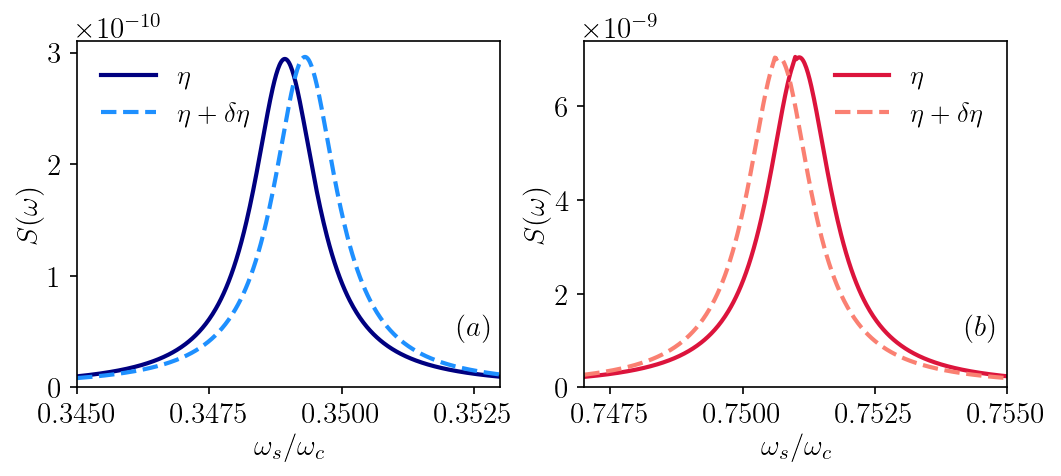

In [292]:
fig, axs = plt.subplots(1, 2, dpi = 150, figsize = (8, 3), gridspec_kw=Dict("hspace"=>0.35, "wspace"=>0.2))

println("Fisher ratio: ", round(100 * fisher_stokes / fisher_direct, digits=2))
println("Peak ratio: ", round(100 * maximum(res_spec_stokes1) / maximum(res_spec_direct1), digits=2))

ax = axs[1]
ax.plot(ωs_list_stokes, res_spec_stokes1, lw=2, color="navy", label=raw"$\eta$")
ax.plot(ωs_list_stokes, res_spec_stokes2, lw=2, color="dodgerblue", ls="--", label=raw"$\eta + \delta \eta$")
ax.set_xlabel(raw"$\omega_s / \omega_c$")
ax.set_ylabel(raw"$S(\omega)$")
ax.set_xlim(ωs_list_stokes[1], ωs_list_stokes[end])
ax.set_ylim(0, nothing)
# ax.set_yscale("log")
ax.text(0.9, 0.15, raw"$(a)$", transform=ax.transAxes, color = "black")
ax.legend()

ax = axs[2]
ax.plot(ωs_list_direct, res_spec_direct1, lw=2, color="crimson", label=raw"$\eta$")
ax.plot(ωs_list_direct, res_spec_direct2, lw=2, color="salmon", ls="--", label=raw"$\eta + \delta \eta$")
ax.set_xlabel(raw"$\omega_s / \omega_c$")
ax.set_ylabel(raw"$S(\omega)$")
ax.set_xlim(ωs_list_direct[1], ωs_list_direct[end])
ax.set_ylim(0, nothing)
# ax.set_yscale("log")
ax.text(0.9, 0.15, raw"$(b)$", transform=ax.transAxes, color = "black")
ax.legend()

root_dir = "/home/alberto/"
# root_dir = "/mnt/c/Users/alber/"
plt.savefig(root_dir * "OneDrive/GitHub/Latex-Projects/phd-thesis/figures/raman_fisher_information.pdf", dpi=300, bbox_inches="tight")